In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import vertexfinder as VF
import datatypes
from datatypes import *

reload(TF)
reload(VF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker/utilities.py'>

### Defining Useful Functions ### 

In [4]:
x_mod_starts = [-1950, -950, 50, 950, 1050]
# y_layer_starts = [8550, 8631.6, 9730, 9811.6, 9893.2, 9974.8, 10056.4, 10138] # 6 layer 
y_layer_starts = [8550, 8631.6, 9893.2, 9974.8, 10056.4, 10138] # 4 layer
n_floors = 2
z_mod_starts = [7000, 8000, 9000, 10000]
# z_wall_starts = [10900, 10981.6, 11063.2, 11144.8, 11226.4, 11308] # 6 layer
z_wall_starts = [10900, 10981.6, 11063.2, 11144.8, 11226.4, 11308] # 4 layer
# back_top =  y_layer_starts[4] # 6 layer
back_top =  y_layer_starts[2] # 4 layer
beam_dim = 10
mod_length = 900
front_wall_starts = [6895.8,6997.4]
steel_height=3 # cm
Box_IP_Depth=8547 # cm   
c = 29.979

wall_floor1 = (7000,8633.2)
wall_floor2 = (7000,8551.6)
wallMid1 = 6896.6
wallMid2 = 6998.2
floorMid1 = 8550.8
floorMid2 = 8632.4

IP = (0,0,0)

y_bottoms = [8550, 8631.6]
z_fronts = [6895.8, 6997.4]
x_lims = (-1950, 1950)
thickness = 1.6

In [5]:
def MakeLayers():
    """
    Returns a list of the layer modules of 
    the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    layers = []
    for i in range(2, len(y_layer_starts)):
        for j in range(len(x_mod_starts)):
            for k in range(len(z_mod_starts)):
                y_min = y_layer_starts[i]; y_max = y_layer_starts[i] + thickness
                x_min = x_mod_starts[j]; x_max = x_mod_starts[j] + mod_length
                z_min = z_mod_starts[k]; z_max = z_mod_starts[k] + mod_length
                layers.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))
    return layers

def MakeBacks():
    """
    Returns a list of the back modules of 
    the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    backs = []
    y_min = back_top - mod_length; y_max = back_top
    for j in range(len(x_mod_starts)):
        for k in range(len(z_wall_starts)):
            x_min = x_mod_starts[j]; x_max = x_mod_starts[j] + mod_length
            z_min = z_wall_starts[k]; z_max = z_wall_starts[k] + thickness
            backs.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))
    return backs

def MakeWalls():
    """
    Returns a list of the hermetic walls of the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    walls = []
    y_min = y_layer_starts[0]; y_max = back_top
    x_min = x_mod_starts[0]; x_max = x_mod_starts[-1] + mod_length
    for i in range(len(front_wall_starts)):
        z_min = front_wall_starts[i]; z_max = front_wall_starts[i] + thickness
        walls.append(np.array(((x_min,x_max),(y_min,y_max),(z_min,z_max))))
    return walls

def MakeFloors():
    """
    Returns a list of the hermetic walls of the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    floors = []
    z_min = z_mod_starts[0]; z_max = z_mod_starts[-1] + mod_length
    x_min = x_mod_starts[0]; x_max = x_mod_starts[-1] + mod_length
    for i in range(n_floors):
        y_min = y_layer_starts[i]; y_max = y_layer_starts[i] + thickness
        floors.append(np.array(((x_min,x_max),(y_min,y_max),(z_min,z_max))))
    return floors
    
def MakeBeams():
    """
    Returns a list with beams of the form 
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    beams = []
    for i in range(len(y_layer_starts) - 1):
        for j in range(len(x_mod_starts)):
            for k in range(len(z_mod_starts)):
                y_min = y_layer_starts[i] + thickness; y_max = y_layer_starts[i+1]
                
                x_min = x_mod_starts[j]; x_max = x_mod_starts[j] + beam_dim
                z_min = z_mod_starts[k]; z_max = z_mod_starts[k] + beam_dim
                beams.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))
                
                x_min = x_mod_starts[j]; x_max = x_mod_starts[j] + beam_dim
                z_min = z_mod_starts[k] + mod_length - beam_dim; z_max = z_mod_starts[k] + mod_length
                beams.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))

                x_min = x_mod_starts[j] + mod_length - beam_dim; x_max = x_mod_starts[j] + mod_length
                z_min = z_mod_starts[k]; z_max = z_mod_starts[k] + beam_dim
                beams.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))

                x_min = x_mod_starts[j] + mod_length - beam_dim; x_max = x_mod_starts[j] + mod_length
                z_min = z_mod_starts[k] + mod_length - beam_dim; z_max = z_mod_starts[k] + mod_length
                beams.append(np.array(((x_min, x_max),(y_min,y_max),(z_min,z_max))))
    return beams

def MakeGround():
    """
    Returns a list with the ground of the form
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    ground = []
    x_min = -9999999; x_max = 9999999
    y_min = -9999999; y_max = 8547
    z_min = -9999999; z_max = 9999999
    ground.append(np.array(((x_min,x_max), (y_min,y_max),(z_min,z_max))))
    return ground

def MakeMaterials():
    """
    Returns all the materials concatenated together
    """
    beams = MakeBeams()
    layers = MakeLayers()
    backs = MakeBacks()
    walls = MakeWalls()
    floors = MakeFloors()
    ground = MakeGround()
    return np.concatenate((beams,layers,backs,walls,floors, ground))

def GetResidual(vertex, rectangle):
    """
    Get the distance between the vertex and a rectangle
    The rectangle is of the form 
    ((x_min, x_max),(y_min,y_max),(z_min, z_max))
    """
    x_min, x_max = rectangle[0]
    y_min, y_max = rectangle[1]
    z_min, z_max = rectangle[2]
    x_v,y_v,z_v = np.array((vertex.x0, vertex.y0, vertex.z0))
    x_clam = max(x_min, min(x_v, x_max))
    y_clam = max(y_min, min(y_v, y_max))
    z_clam = max(z_min, min(z_v, z_max))
    return np.array(((x_v - x_clam), (y_v - y_clam), (z_v - z_clam)))

def GetChi2(vertex, rectangle):
    """
    Get the chi2 between the vertex and the rectangle
    """
    res = GetResidual(vertex, rectangle)
    trimmed_cov = np.delete(vertex.cov, 3, 0)
    trimmed_cov = np.delete(trimmed_cov, 3, 1)
    return res.T@np.linalg.inv(trimmed_cov)@res

def MinDistance(vertex):
    """
    Returns the minimum distance to a material
    """
    materials = MakeMaterials()
    min_dist = None
    for material in materials:
        res = GetResidual(vertex, material)
        dist = np.sqrt(res[0]**2 + res[1]**2 + res[2]**2)
        if min_dist is None or dist < min_dist:
            min_dist = dist
    return min_dist

def MinChi2(vertex):
    """
    Returns the minimum chi2 of the vertex
    """
    materials = MakeMaterials()
    min_chi2 = None
    for material in materials:
        chi2 = GetChi2(vertex, material)
        if min_chi2 is None or chi2 < min_chi2:
            min_chi2 = chi2
    return min_chi2
    

# Background #

In [6]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

187


## Chi2 Distribution ##

In [7]:
chi2s = []
dists = []
beams = MakeBeams()
layers = MakeLayers()
backs = MakeBacks()
walls = MakeWalls()
floors = MakeFloors()
materials = np.concatenate((beams,layers,backs,walls,floors))
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        min_chi2 = None
        min_dist = None
        for vertex in vertices:
            for material in materials:
                chi2 = GetChi2(vertex, material)
                if min_chi2 is None or chi2 < min_chi2:
                    res = GetResidual(vertex, material)
                    min_dist = np.sqrt(res[0]**2 + res[1]**2 + res[2]**2)
                    min_chi2 = chi2
            chi2s.append(min_chi2)
            dists.append(min_dist)

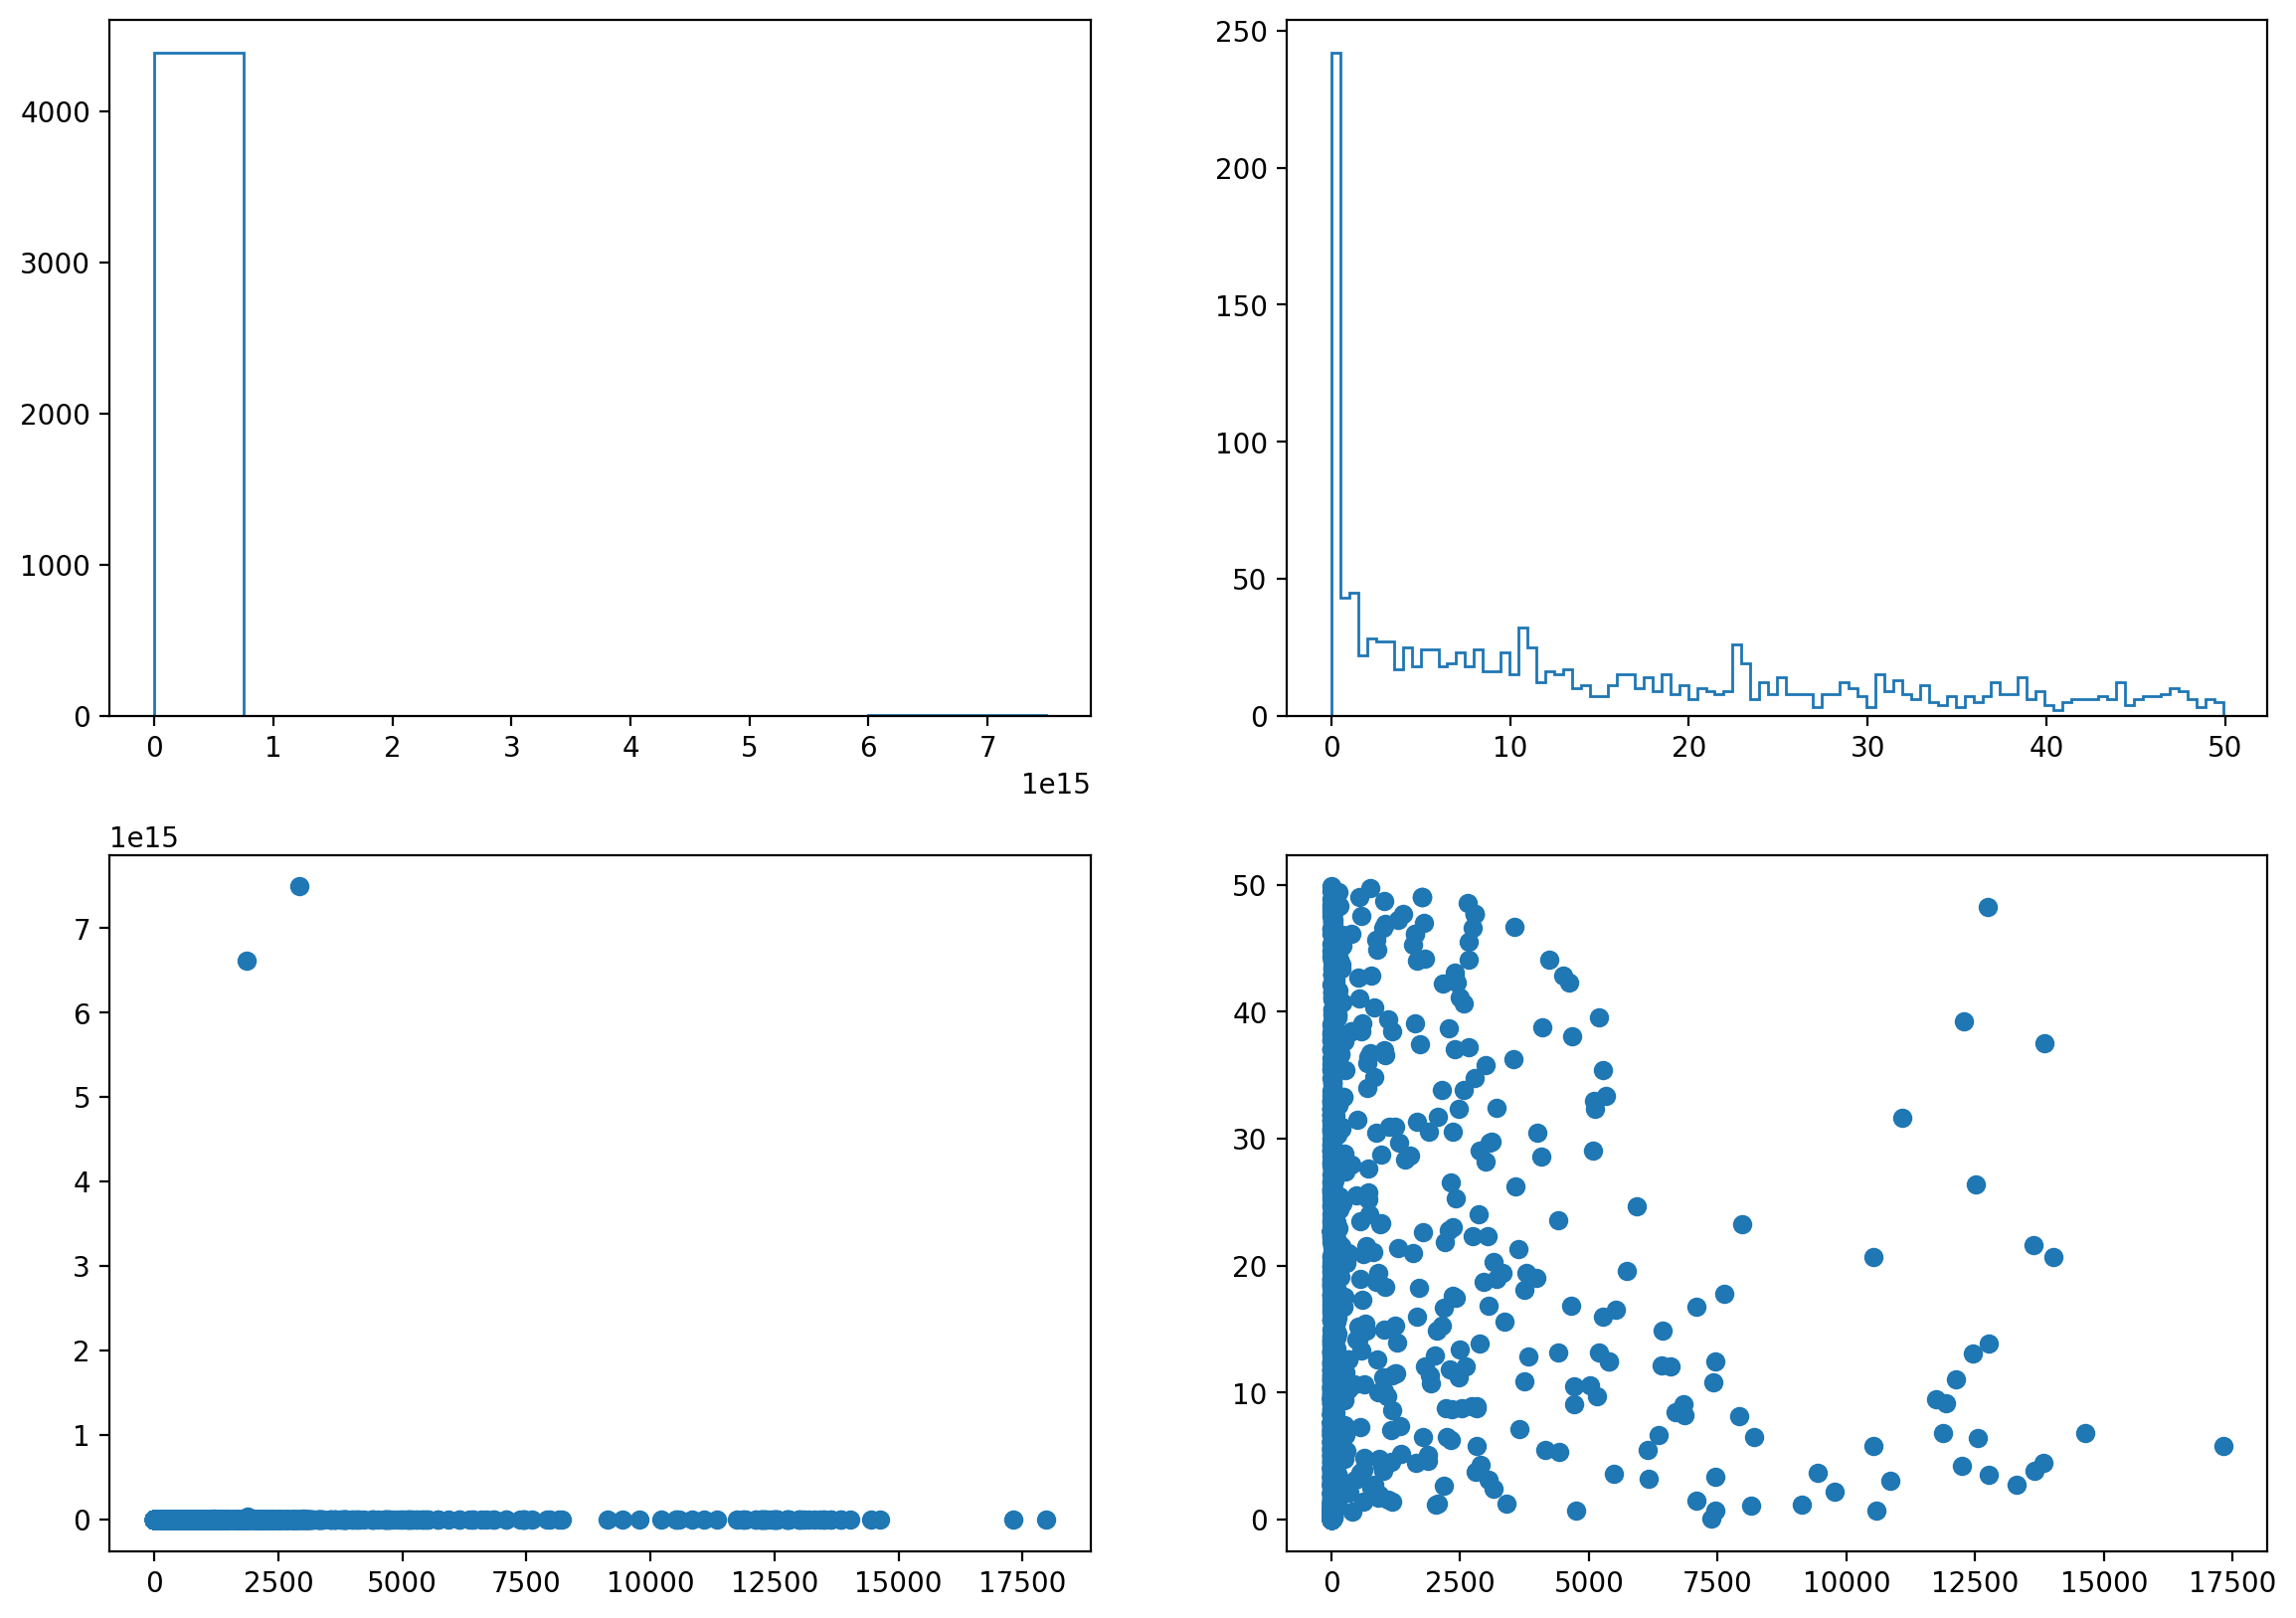

In [8]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

zoomedchi2 = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 50:
        zoomedchi2.append(chi2s[i])
        zoomeddist.append(dists[i])

chi2Counts, chi2Bins = np.histogram(chi2s)
zoomedCounts, zoomedBins = np.histogram(zoomedchi2, bins=100)

axs[0].stairs(chi2Counts, chi2Bins)
axs[1].stairs(zoomedCounts, zoomedBins)
axs[2].scatter(dists, chi2s)
axs[3].scatter(zoomeddist,zoomedchi2)

## Distance Distribution ##

In [9]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            min_dist = MinDistance(vertex)
        distances.append(min_dist)

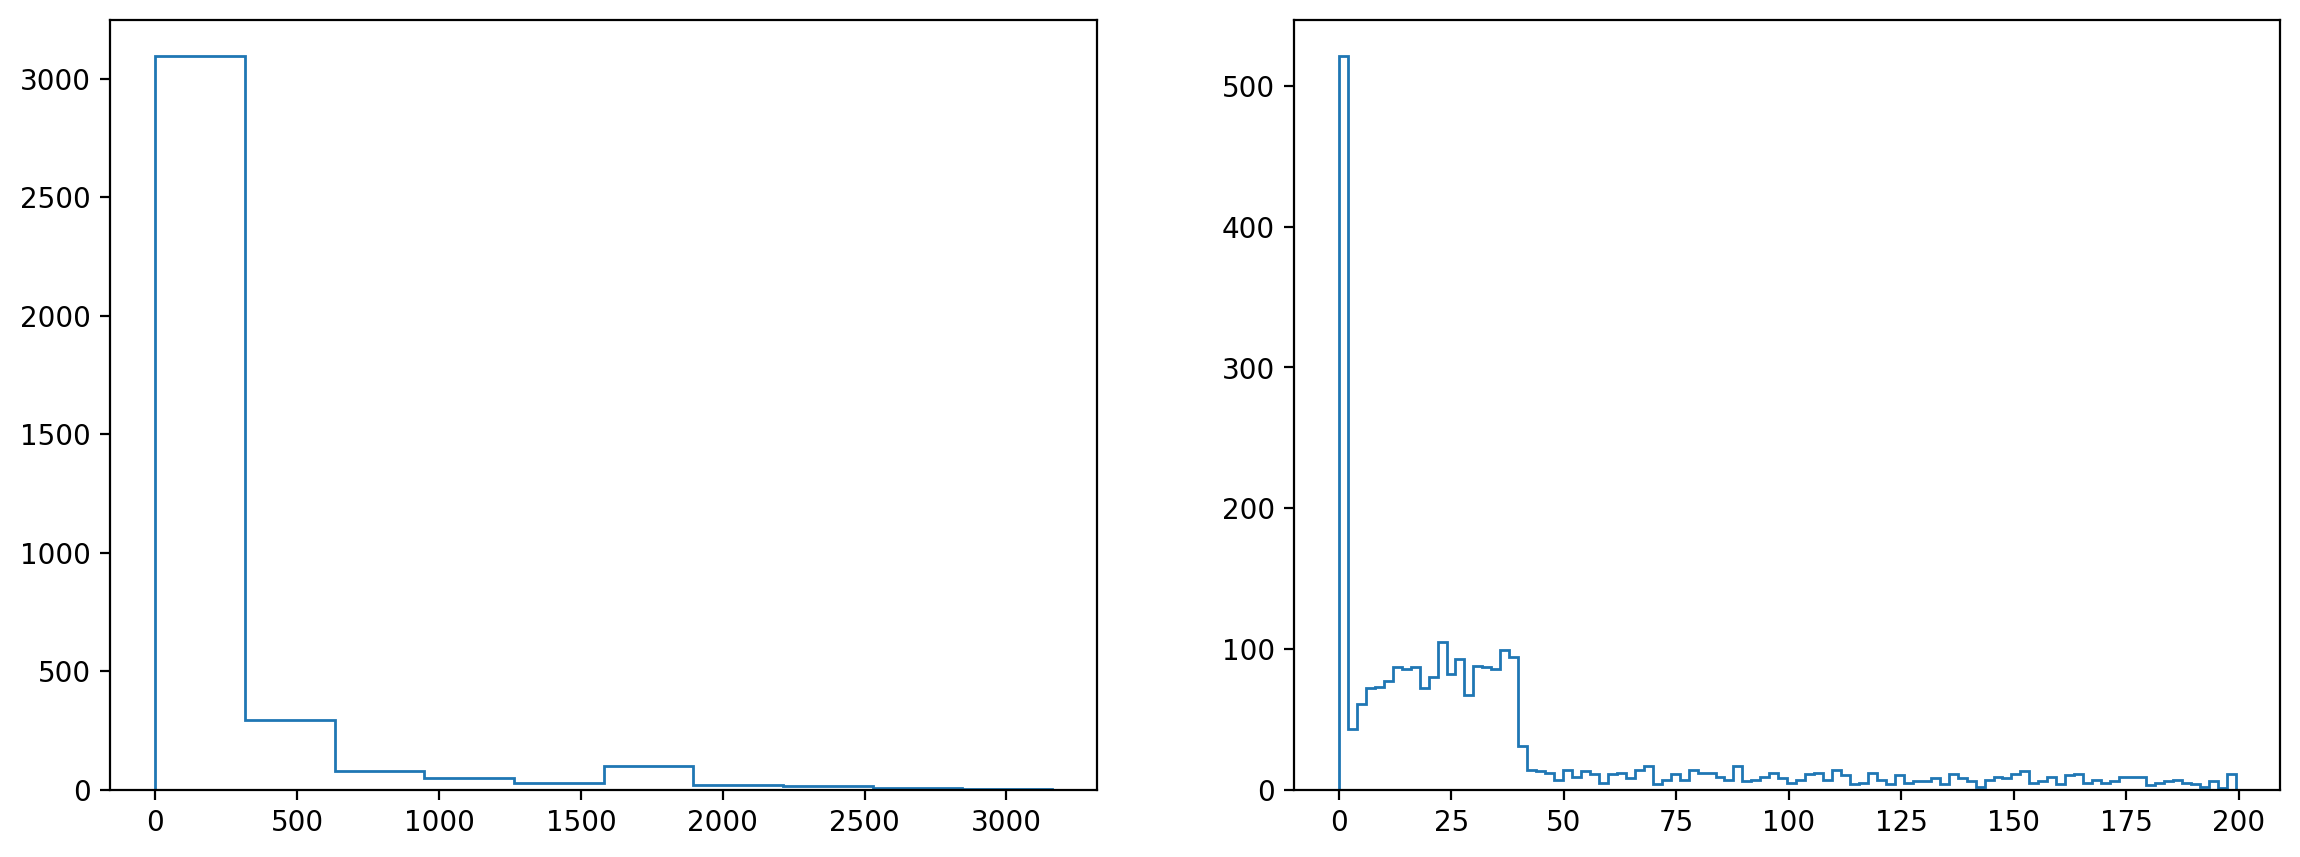

In [10]:
fig,axs=plt.subplots(1,2,figsize=(14,5))
axs=axs.flatten().tolist()

zoomeddist = []
for i in range(len(distances)):
    if distances[i] < 200:
        zoomeddist.append(distances[i])

distCounts, distBins = np.histogram(distances, bins=100)
zoomedCounts, zoomedBins = np.histogram(zoomeddist, bins=100)

axs[0].stairs(distCounts, distBins)
axs[1].stairs(zoomedCounts, zoomedBins)

## Survival Rate ##

In [11]:
nVertices = 0
dists = [0.01,1,2,5,10,25,50,100]
counts = []
for dist in dists:
    counts.append([])
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        nVertices += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            dist = MinDistance(vertex)
            for i in range(len(dists)):
                if vertex.y0 < 8547:
                    counts[i].append(0)
                elif dist < dists[i]:
                    counts[i].append(dist)
print("Total Vertices:", nVertices)

Total Vertices: 4389


Distance 0.01 cm survival rate: 0.8879015721120984
Distance 1 cm survival rate: 0.8808384597858282
Distance 2 cm survival rate: 0.8740031897926634
Distance 5 cm survival rate: 0.848712690817954
Distance 10 cm survival rate: 0.7969924812030076
Distance 25 cm survival rate: 0.6206425153793576
Distance 50 cm survival rate: 0.41740715424925956
Distance 100 cm survival rate: 0.34426976532239695


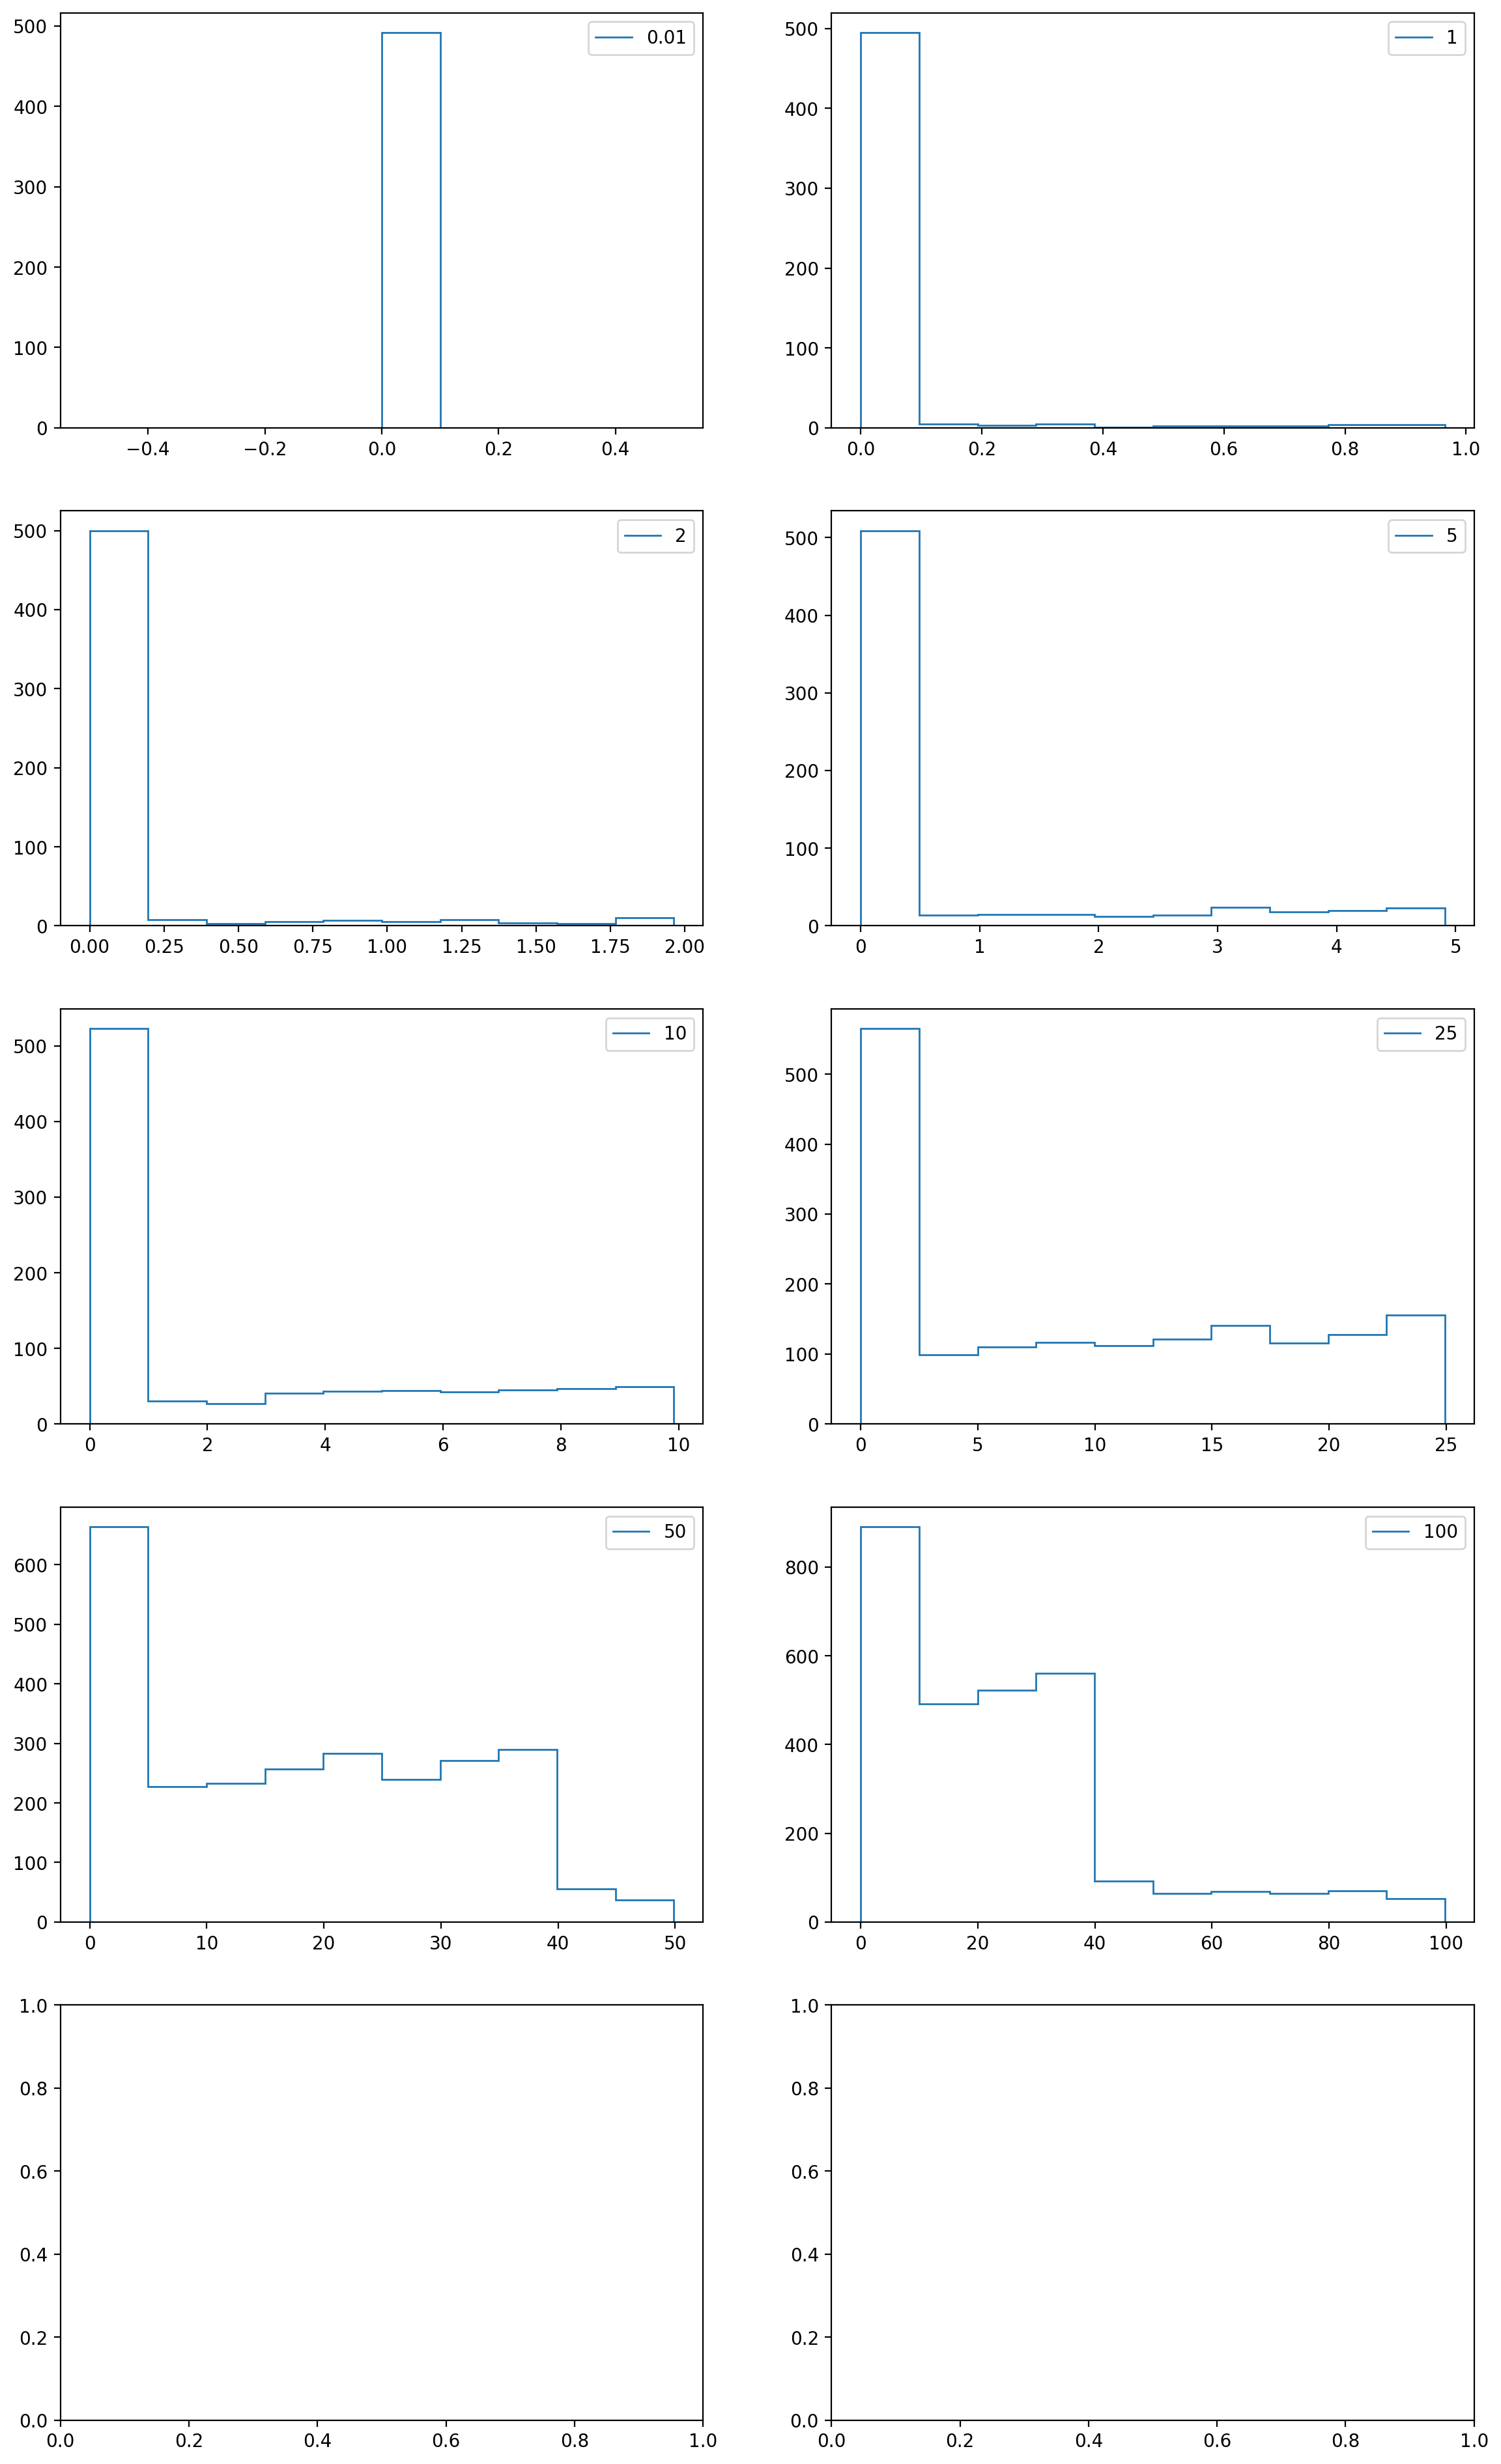

In [12]:
fig,axs=plt.subplots(int(len(dists)/2) + 1,2,figsize=(14,int(6*len(dists)/2)))
axs=axs.flatten().tolist()


for i in range(len(dists)):
    if len(counts[i]) == 0:
        print("Distance of " + str(dists[i]) + " had no counts")
        continue
    distCounts, distBins = np.histogram(counts[i])
    print("Distance " + str(dists[i]) + " cm survival rate:", 1 - sum(distCounts)/nVertices)
    lab = str(dists[i])
    axs[i].stairs(distCounts, distBins, label=lab)
    axs[i].legend()

# Chi

# Checking Beam Placement #

Text(0, 0.5, 'y')

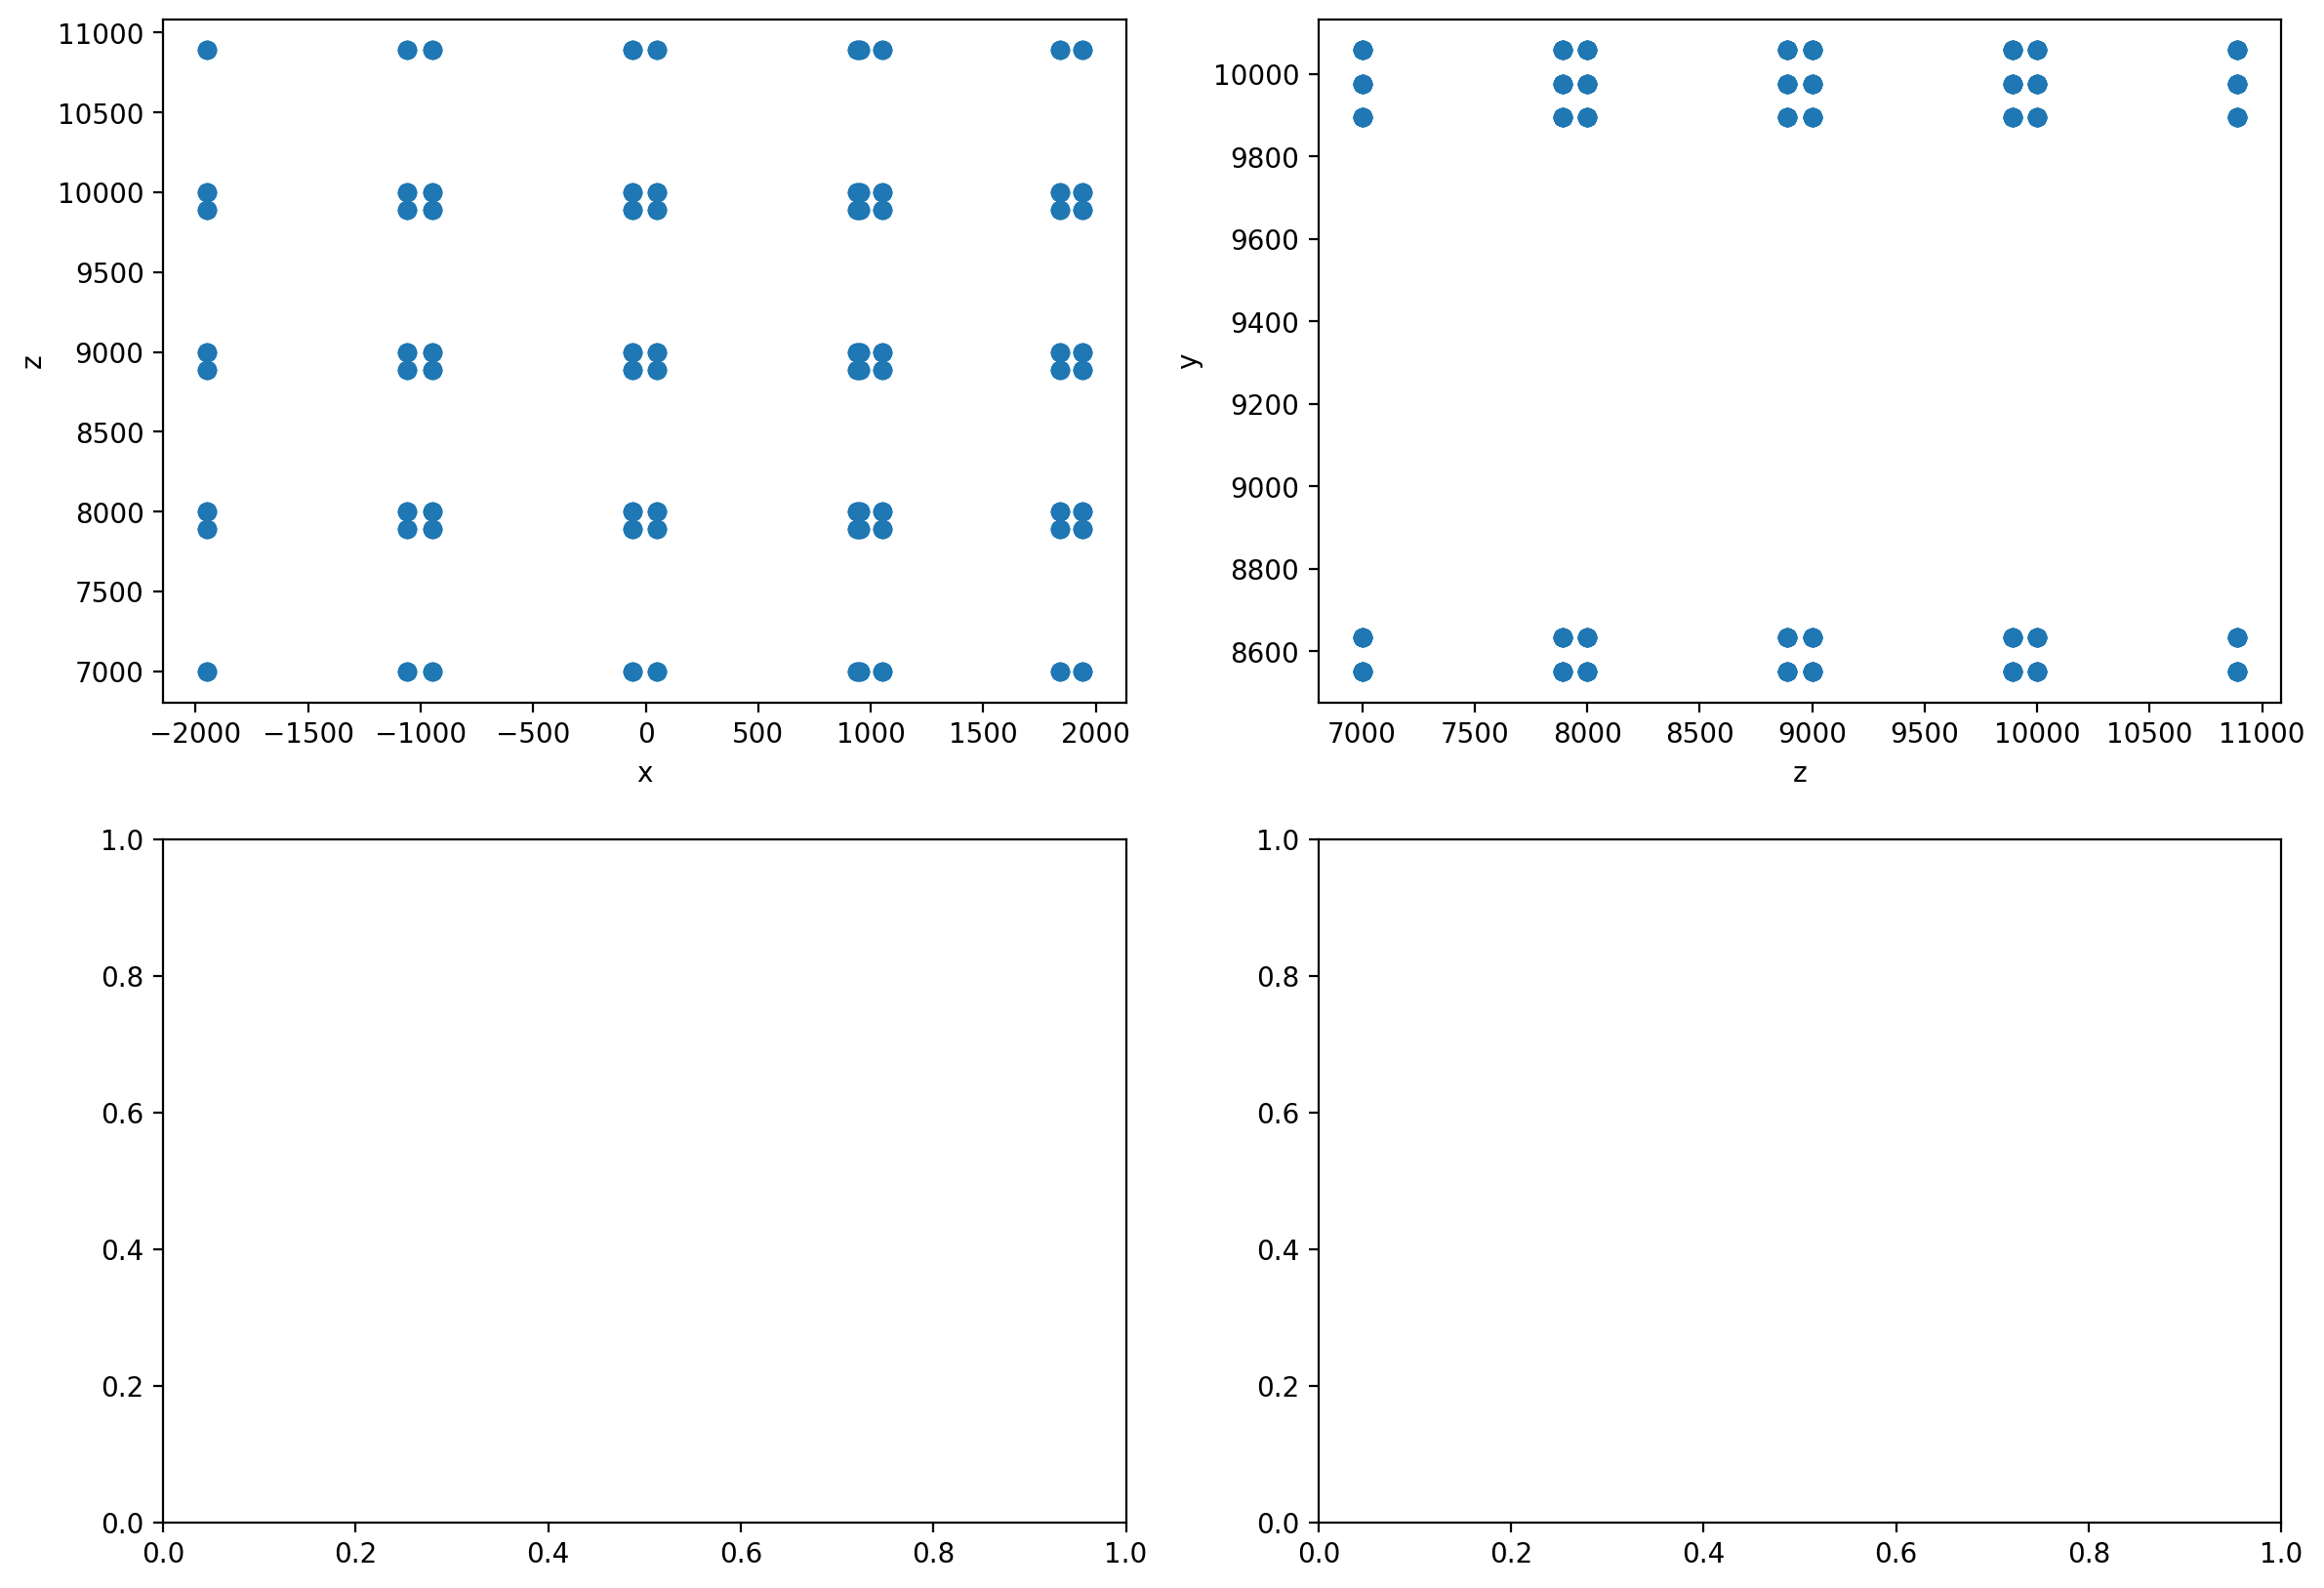

In [13]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

beams = MakeBeams()
x_min=[];y_min =[];z_min=[]
for beam in beams:
    x_min.append(beam[0][0])
    y_min.append(beam[1][0])
    z_min.append(beam[2][0])
axs[0].scatter(x_min, z_min)
axs[0].set_xlabel("x")
axs[0].set_ylabel("z")
axs[1].scatter(z_min, y_min)
axs[1].set_xlabel("z")
axs[1].set_ylabel("y")
    

# Signal #

In [14]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/LLP"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

5


## Distance Distribution ##

In [15]:
distances = []
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            min_dist = MinDistance(vertex)
        distances.append(min_dist)

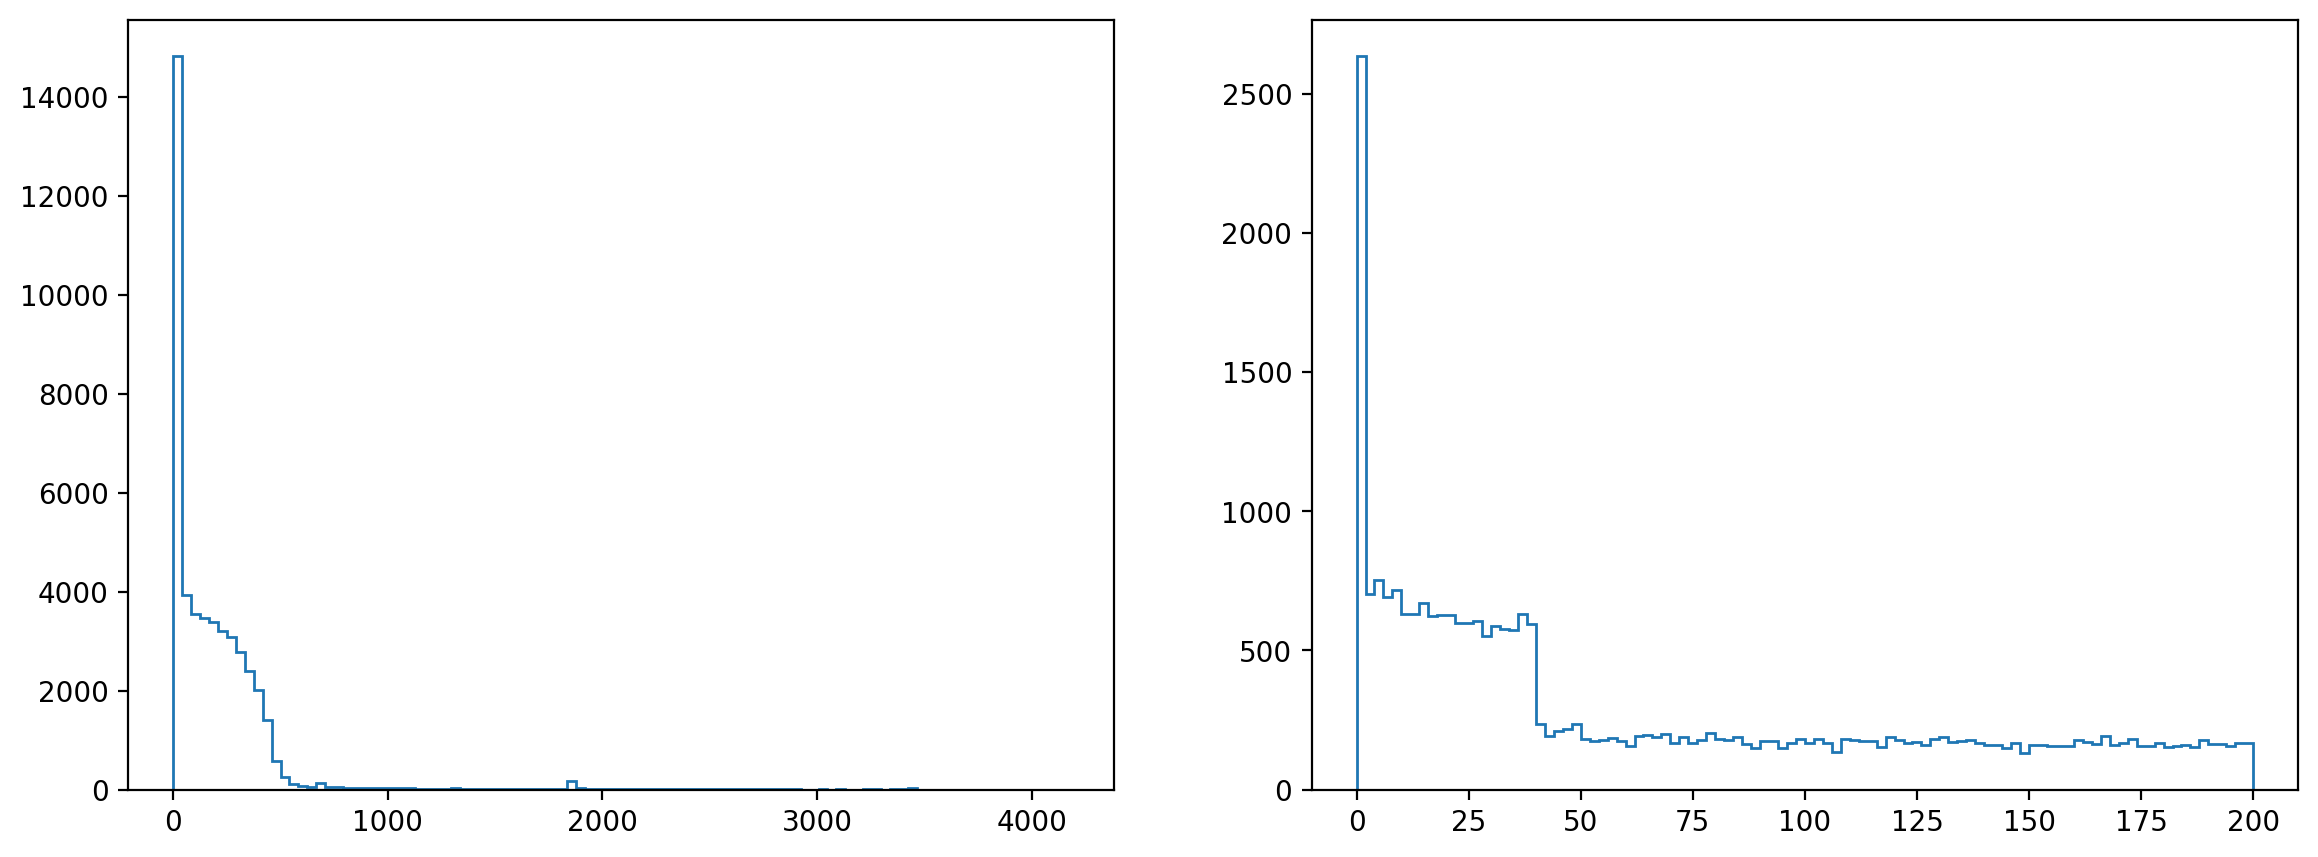

In [16]:
fig,axs=plt.subplots(1,2,figsize=(14,5))
axs=axs.flatten().tolist()

zoomeddist = []
for i in range(len(distances)):
    if distances[i] < 200:
        zoomeddist.append(distances[i])

distCounts, distBins = np.histogram(distances, bins=100)
zoomedCounts, zoomedBins = np.histogram(zoomeddist, bins=100)

axs[0].stairs(distCounts, distBins)
axs[1].stairs(zoomedCounts, zoomedBins)

## Survival Rate ##

In [17]:
nVertices = 0
dists = [0.01,1,2,5,10,25,50,100]
counts = []
for dist in dists:
    counts.append([])
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        nVertices += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            dist = MinDistance(vertex)
            for i in range(len(dists)):
                if vertex.y0 < 8547:
                    counts[i].append(0)
                elif dist < dists[i]:
                    counts[i].append(dist)
print("Total Vertices:", nVertices)

Total Vertices: 118152


Distance 0.01 cm survival rate: 0.9685743787663349
Distance 1 cm survival rate: 0.9623366510935066
Distance 2 cm survival rate: 0.9548378360078543
Distance 5 cm survival rate: 0.9315711964249441
Distance 10 cm survival rate: 0.8934169544315796
Distance 25 cm survival rate: 0.7898892951452366
Distance 50 cm survival rate: 0.6615122892545195
Distance 100 cm survival rate: 0.5572652176856929


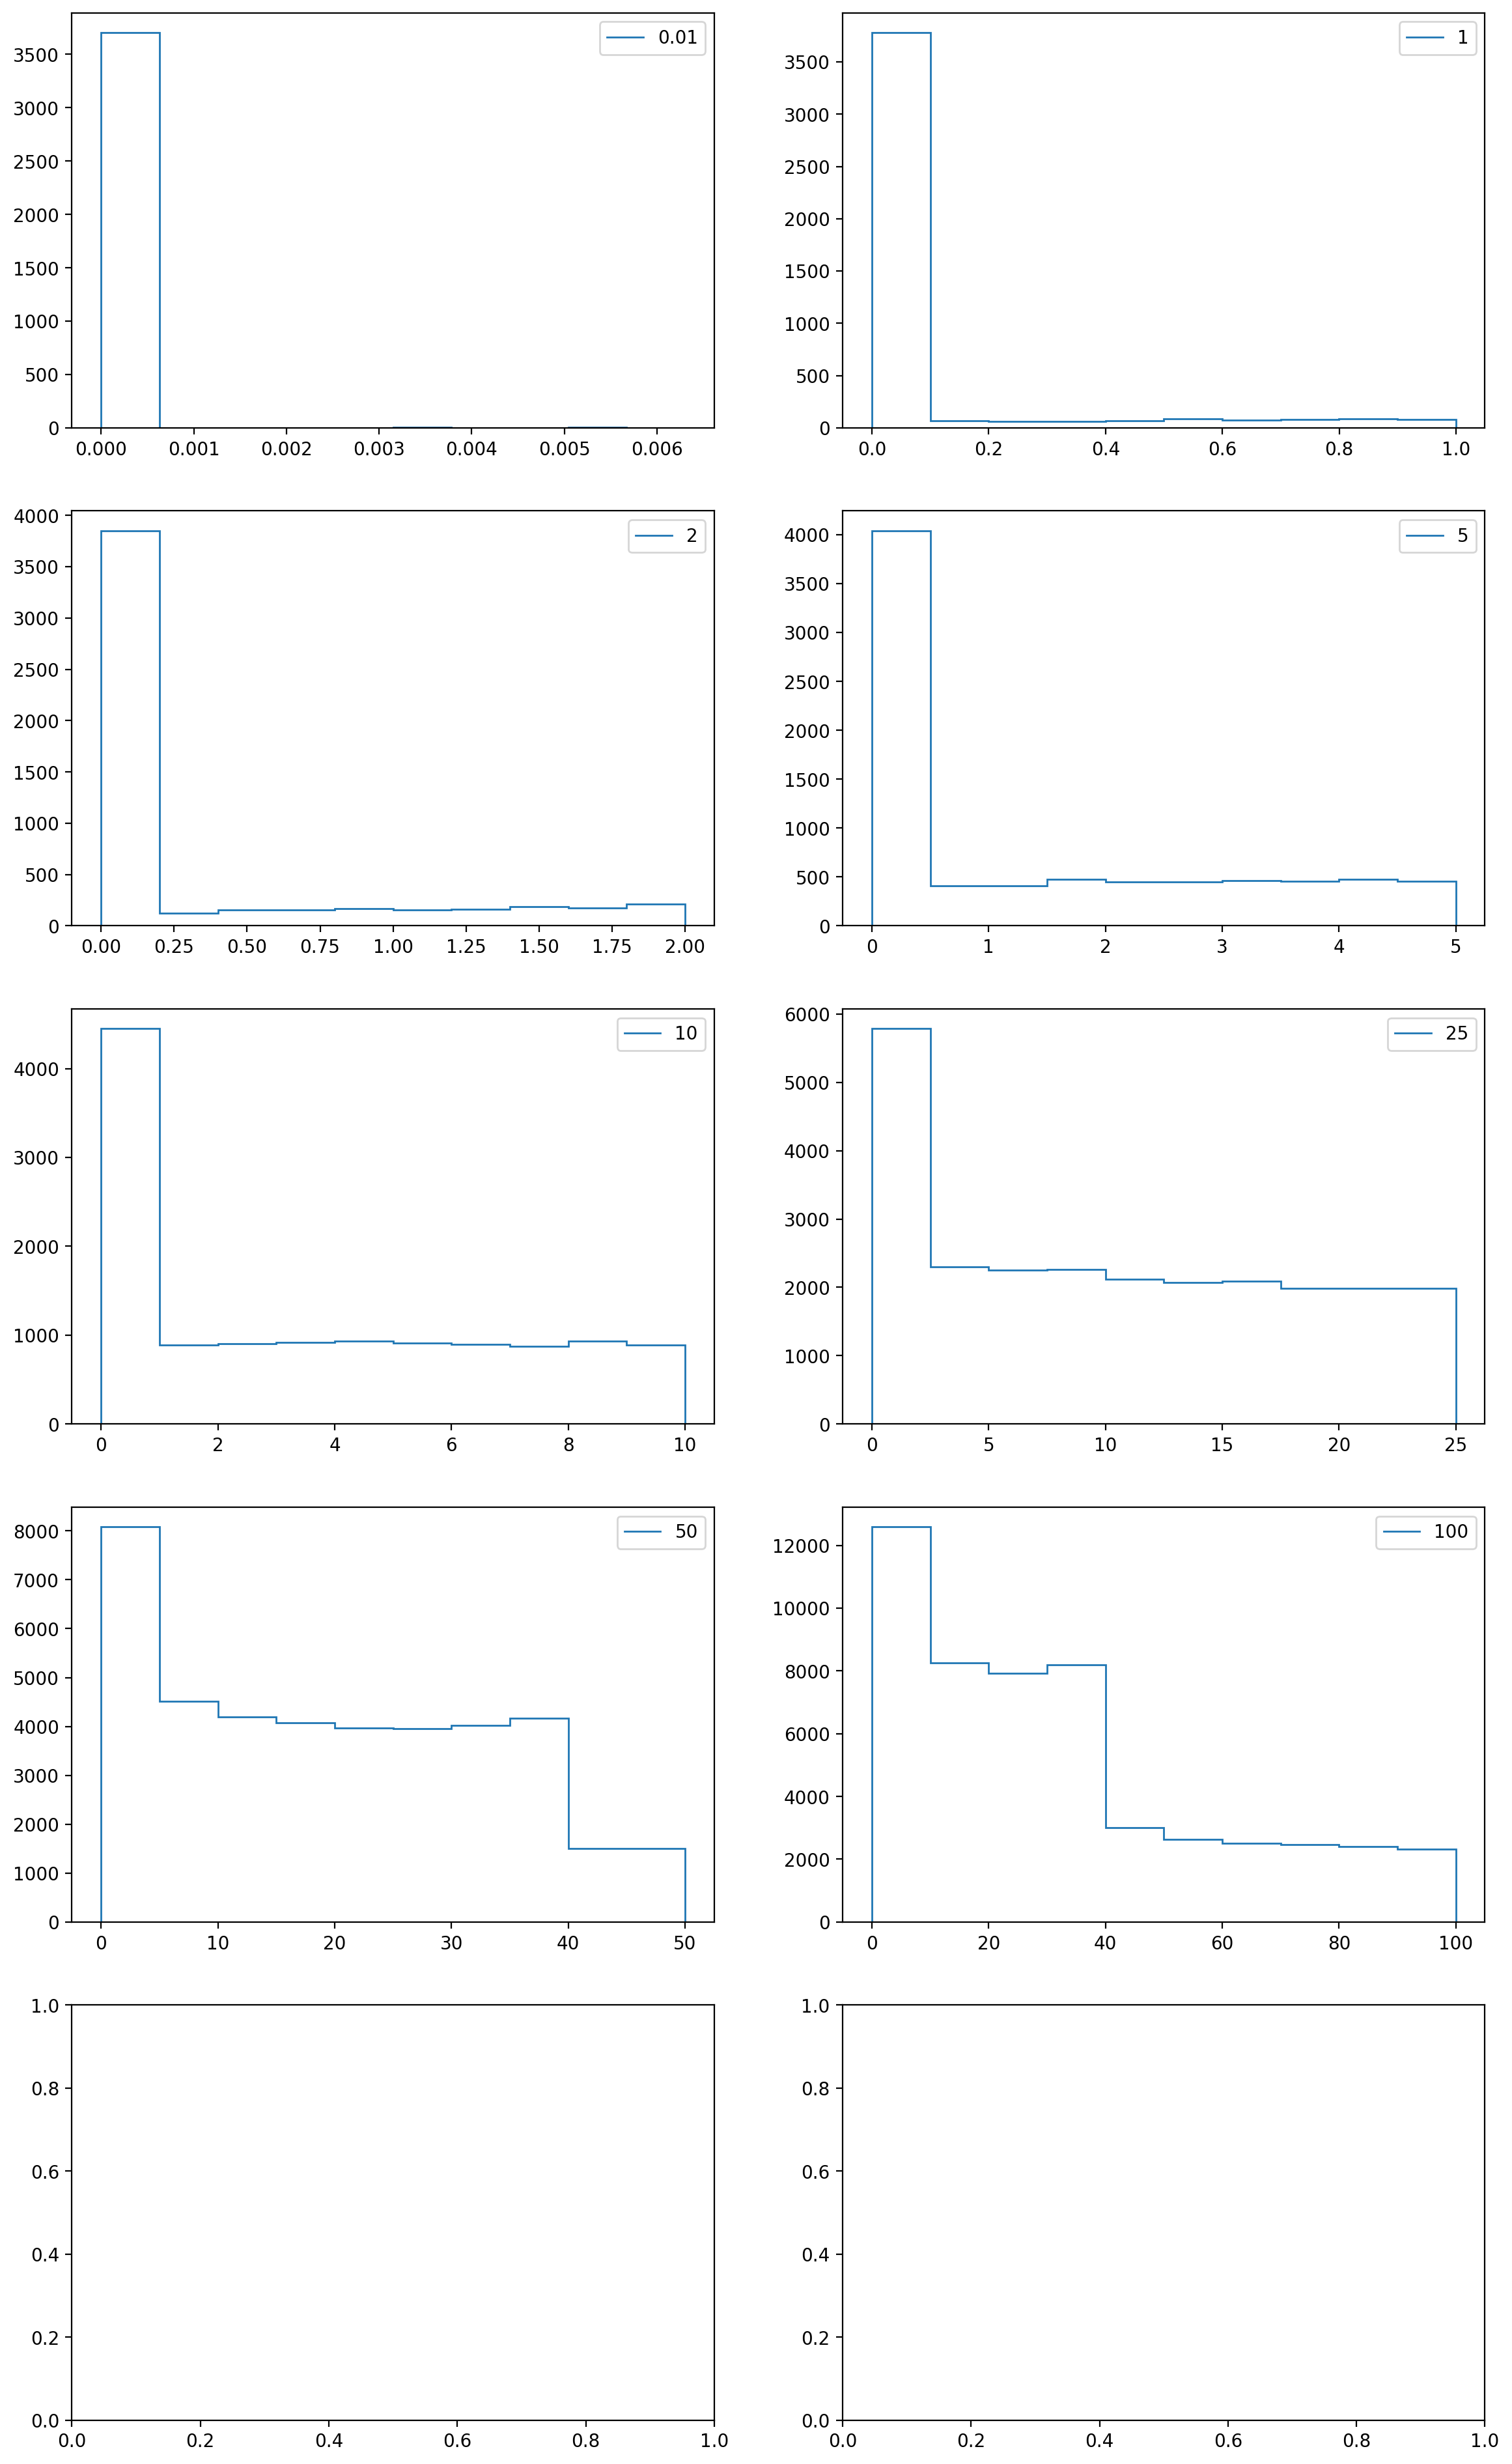

In [18]:
fig,axs=plt.subplots(int(len(dists)/2) + 1,2,figsize=(14,int(6*len(dists)/2)))
axs=axs.flatten().tolist()


for i in range(len(dists)):
    if len(counts[i]) == 0:
        print("Distance of " + str(dists[i]) + " had no counts")
        continue
    distCounts, distBins = np.histogram(counts[i])
    print("Distance " + str(dists[i]) + " cm survival rate:", 1 - sum(distCounts)/nVertices)
    lab = str(dists[i])
    axs[i].stairs(distCounts, distBins, label=lab)
    axs[i].legend()